This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Deep learning for timeseries

## Different kinds of timeseries tasks

## A temperature forecasting example

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2025-11-12 00:39:01--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.129.136, 54.231.132.232, 16.15.202.8, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.129.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  21.3MB/s    in 0.6s    

2025-11-12 00:39:02 (21.3 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset**

In [ ]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [ ]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

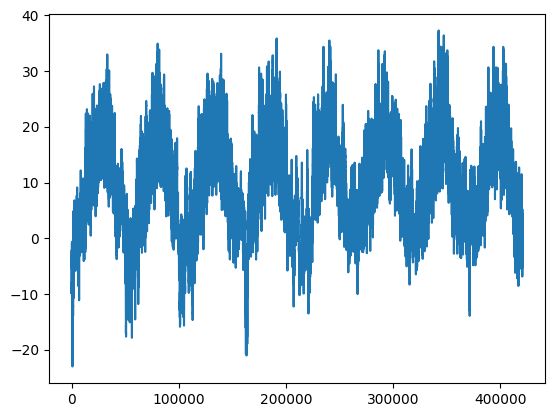

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

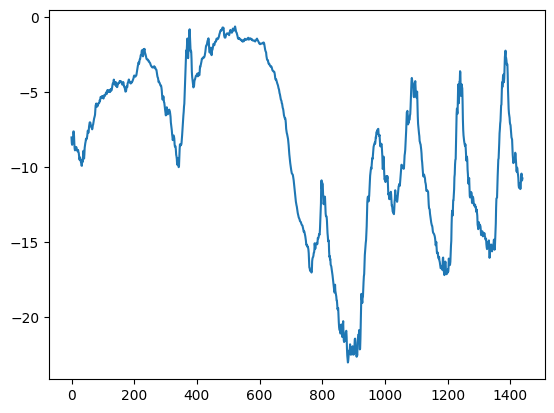

In [ ]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split.**

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [ ]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating Datasets for training, validation, and testing.**

In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our Datasets.**

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine learning model

**Training and evaluating a densely connected model**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

flattened_dim = sequence_length * raw_data.shape[-1]
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Reshape((flattened_dim,))(inputs) # Replaced Flatten with Reshape
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 54s 65ms/step - loss: 22.4409 - mae: 3.5681 - val_loss: 10.3351 - val_mae: 2.5442
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 53s 64ms/step - loss: 9.4825 - mae: 2.4286 - val_loss: 10.6925 - val_mae: 2.5934
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 54s 66ms/step - loss: 8.7374 - mae: 2.3302 - val_loss: 10.4139 - val_mae: 2.5601
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 55s 66ms/step - loss: 8.1942 - mae: 2.2567 - val_loss: 10.2164 - val_mae: 2.5298
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 52s 63ms/step - loss: 7.6708 - mae: 2.1832 - val_loss: 10.5486 - val_mae: 2.5704
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 53s 65ms/step - loss: 7.4201 - mae: 2.1475 - val_loss: 11.2482 - val_mae: 2.6563
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 53s 65ms/step - loss: 7.2232 - mae: 2.1184 - val_loss: 11.8361 - val_mae: 2.7214
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 53s 64ms/step - loss: 7.0445 - mae: 2.0966 - val_loss: 11.1743 - val_mae: 2.6391
Epoch 9/10
819/819 ━━━━━━━━━━━━

**Plotting results**

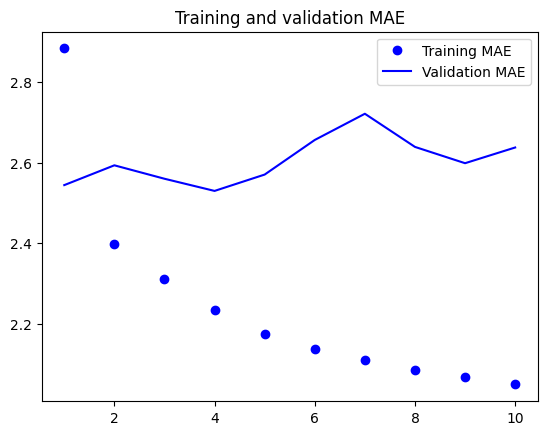

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 84s 101ms/step - loss: 34.7531 - mae: 4.4477 - val_loss: 15.7236 - val_mae: 3.1351
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 84s 102ms/step - loss: 15.6376 - mae: 3.1469 - val_loss: 17.1976 - val_mae: 3.2389
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 83s 100ms/step - loss: 14.4984 - mae: 3.0240 - val_loss: 16.9924 - val_mae: 3.2402
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 79s 96ms/step - loss: 13.7504 - mae: 2.9395 - val_loss: 16.0989 - val_mae: 3.1427
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 85s 103ms/step - loss: 13.0612 - mae: 2.8584 - val_loss: 14.4415 - val_mae: 3.0062
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 83s 101ms/step - loss: 12.4800 - mae: 2.7917 - val_loss: 14.6238 - val_mae: 3.0126
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 81s 98ms/step - loss: 12.0452 - mae: 2.7402 - val_loss: 15.3921 - val_mae: 3.0861
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 84s 102ms/step - loss: 11.6902 - mae: 2.6934 - val_loss: 14.1314 - val_mae: 2.9636
Epoch 9/10
819/819

### A first recurrent baseline

**A simple LSTM-based model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print("Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 101s 121ms/step - loss: 72.8108 - mae: 6.5249 - val_loss: 12.5502 - val_mae: 2.6974
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 97s 118ms/step - loss: 12.0406 - mae: 2.6738 - val_loss: 9.6332 - val_mae: 2.4176
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 99s 120ms/step - loss: 9.8626 - mae: 2.4503 - val_loss: 10.1006 - val_mae: 2.4637
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 98s 120ms/step - loss: 9.2888 - mae: 2.3749 - val_loss: 10.5373 - val_mae: 2.4979
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 140s 117ms/step - loss: 8.9038 - mae: 2.3209 - val_loss: 10.2959 - val_mae: 2.4908
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 100s 122ms/step - loss: 8.5789 - mae: 2.2796 - val_loss: 10.1621 - val_mae: 2.4851
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 97s 118ms/step - loss: 8.3356 - mae: 2.2533 - val_loss: 11.0683 - val_mae: 2.5801
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 141s 118ms/step - loss: 8.1244 - mae: 2.2275 - val_loss: 10.5185 - val_mae: 2.5185
Epoch 9/10
819/819 

## Understanding recurrent neural networks

**NumPy implementation of a simple RNN**

In [ ]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.concatenate(successive_outputs, axis=0)

### A recurrent layer in Keras

**A RNN layer that can process sequences of any length**

In [ ]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**A RNN layer that returns only its last output step**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**A RNN layer that returns its full output sequence**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking RNN layers**

In [ ]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 138s 165ms/step - loss: 55.0302 - mae: 5.4873 - val_loss: 10.7694 - val_mae: 2.5518
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 137s 167ms/step - loss: 9.9777 - mae: 2.4704 - val_loss: 10.1240 - val_mae: 2.4641
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 133s 162ms/step - loss: 8.8133 - mae: 2.3121 - val_loss: 9.8636 - val_mae: 2.4395
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 135s 164ms/step - loss: 8.2580 - mae: 2.2329 - val_loss: 10.4087 - val_mae: 2.5040
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 135s 165ms/step - loss: 7.8571 - mae: 2.1781 - val_loss: 11.0110 - val_mae: 2.5687
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 136s 165ms/step - loss: 7.4838 - mae: 2.1229 - val_loss: 10.6372 - val_mae: 2.5285
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 134s 163ms/step - loss: 7.1790 - mae: 2.0785 - val_loss: 10.9170 - val_mae: 2.5765
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 135s 164ms/step - loss: 6.9608 - mae: 2.0458 - val_loss: 10.7797 - val_mae: 2.5610
Epoch 9/10
819/8